## Data Ingestion & Exploratory Data Analysis

1. The dataset contains transactions made by credit cards in September 2013 by European cardholders.
2. This dataset presents transactions that occurred in **two days**, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

3. **It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.** Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from xgboost import Booster
from xgboost import DMatrix
from sklearn import metrics
from datetime import datetime


In [35]:
dataDF = pd.read_csv("creditcard.csv")
dataDF.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,...,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,...,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,...,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0
3,1.000,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,...,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.500,0
4,2.000,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,...,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.990,0


In [36]:
#size of the datset, it contains 284807 rows and 31 coloumns 
dataDF.shape

(284807, 31)

#### Ratio of fraudulent transactions and legitimate transactions.

<Axes: title={'center': 'Class distribution of the target variable'}, xlabel='Class'>

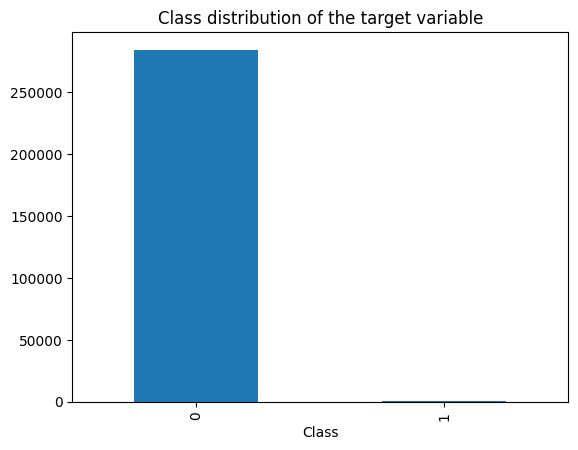

In [37]:
value_counts = dataDF["Class"].value_counts()
value_counts.plot(kind="bar", title="Class distribution of the target variable")

1. Fraudulent transactions are 0.17% of the complete dataset. 
2. As expected, the majority of the samples are legitimate transactions. Only 0.17% of the transactions are flagged as fraudulent.

In [38]:
# Let's also look at the basic descriptive statistics for all attributes.
# This piece of code modifies the display format for floating-point numbers in the pandas DataFrame
# A floating-point number 3.14159265, this line of code will change its display format to 3.142.

pd.set_option("display.float_format", lambda x: "%.3f" % x)
dataDF.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,...,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000
mean,94813.860,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,...,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,88.350,0.002
std,47488.146,1.959,1.651,1.516,1.416,1.380,1.332,1.237,1.194,1.099,...,0.735,0.726,0.624,0.606,0.521,0.482,0.404,0.330,250.120,0.042
min,0.000,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,...,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,0.000,0.000
25%,54201.500,-0.920,-0.599,-0.890,-0.849,-0.692,-0.768,-0.554,-0.209,-0.643,...,-0.228,-0.542,-0.162,-0.355,-0.317,-0.327,-0.071,-0.053,5.600,0.000
50%,84692.000,0.018,0.065,0.180,-0.020,-0.054,-0.274,0.040,0.022,-0.051,...,-0.029,0.007,-0.011,0.041,0.017,-0.052,0.001,0.011,22.000,0.000
75%,139320.500,1.316,0.804,1.027,0.743,0.612,0.399,0.570,0.327,0.597,...,0.186,0.529,0.148,0.440,0.351,0.241,0.091,0.078,77.165,0.000
max,172792.000,2.455,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,...,27.203,10.503,22.528,4.585,7.520,3.517,31.612,33.848,25691.160,1.000


**Inspecting the statistics above reveals that the V1-V28 attributes are zero-centered, but this is not the case for the other two input attributes Time and Amount.**

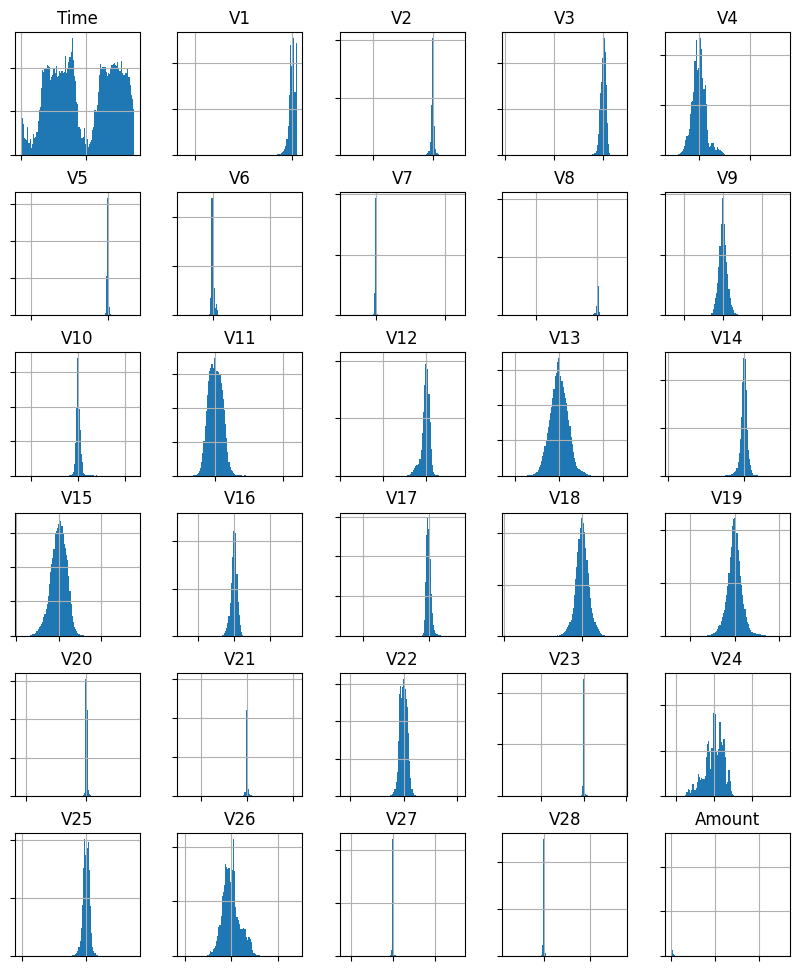

In [39]:
# We can also plot the histograms for all input attributes and make sure nothing unusual stands out.
ax = dataDF.drop("Class", axis=1).hist(figsize=(10,12),bins=100)
# We hide the axes' labels to make the plot neater and more compact
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])

**First of all, the basic statistics for Time suggest that this attribute is given as a timestamp (seconds). We can convert it to local date and extract the hours in an attempt to identify if the hour of the transaction is correlated with the possibility of a transaction being fraudulent.**

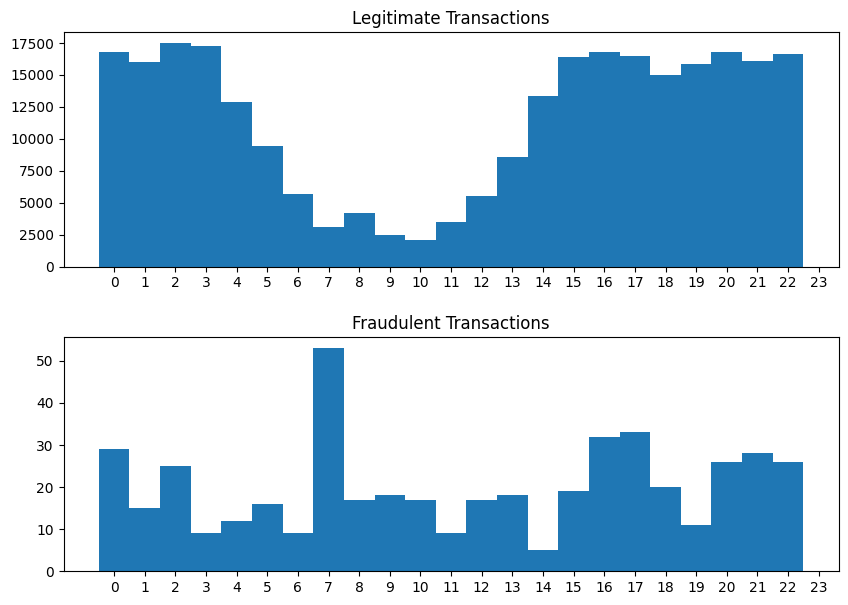

In [40]:
dataDF["Hour"] = dataDF["Time"].apply(datetime.fromtimestamp).dt.hour
fig, ax = plt.subplots(2, figsize=(10,7))
for a in ax:
    a.set_xticks(range(24))
# This line plots the histogram for the "Hour" column of legitimate transactions 
dataDF.loc[dataDF["Class"] == 0]["Hour"].hist(bins=np.arange(24)-0.5, ax=ax[0], grid=False)
# This line plots the histogram for the "Hour" column of fraudulent transactions (where "Class" equals 1) 
dataDF.loc[dataDF["Class"] == 1]["Hour"].hist(bins=np.arange(24)-0.5, ax=ax[1], grid=False)
ax[0].title.set_text("Legitimate Transactions")
ax[1].title.set_text("Fraudulent Transactions")
plt.subplots_adjust(hspace=0.3)

It appears that the legitimate transactions plunge during the night and their rate increases with the start of the working day. In contrast, there is a peak of fraudulent transactions at around 2am that looks unusual. In addition, the data for the fraudulent transactions looks more evenly spread.

###  Let's write a simple function that will allow us to compare the basic statistics for a single attribute across the fraud/no-fraud classes.

In [41]:
def compare_leg_fraud(attribute):
    leg_trS = dataDF.loc[dataDF["Class"] == 0][attribute].rename("Legitimate").describe()
    frd_trS = dataDF.loc[dataDF["Class"] == 1][attribute].rename("Fraudulent").describe()
    tr_hourDF = leg_trS.to_frame().join(frd_trS.to_frame())
    return tr_hourDF

#### Let's also look at the basic statistics for the Hour attribute.

In [42]:
compare_leg_fraud("Hour")

,Legitimate,Fraudulent
count,284315.000,492.000
mean,12.349,12.136
std,7.805,7.227
min,0.000,0.000
25%,4.000,7.000
50%,15.000,12.500
75%,19.000,18.000
max,23.000,23.000


The fraudulent transactions definitely have a higher standard deviation, but given their relatively low number we can't be certain if this is a genuine pattern or just a statistical coincidence.

**We now shift our attention to the transaction amount.** 

#### Let's visualise the distribution of fraudulent vs legitimate transaction AMOUNT via histograms.

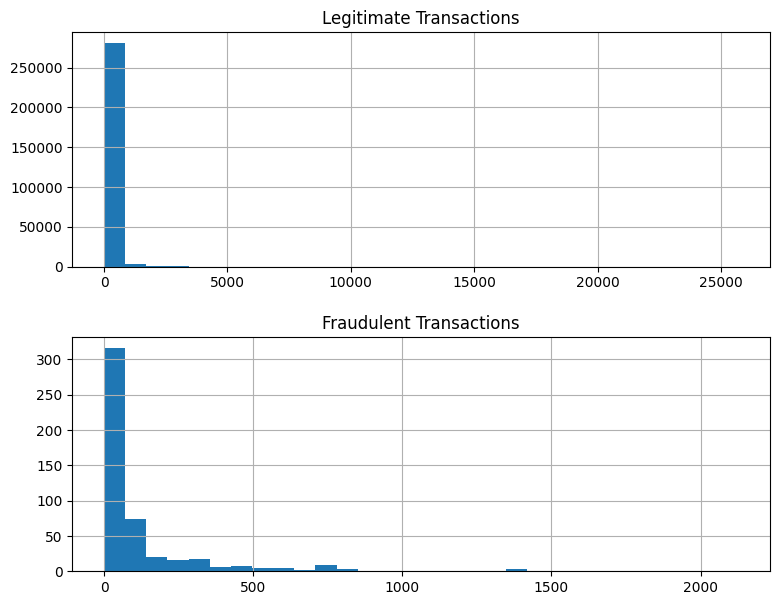

In [43]:
fig, ax = plt.subplots(2, figsize=(9,7))
dataDF.loc[dataDF["Class"] == 0]["Amount"].hist(bins=30, ax=ax[0])
dataDF.loc[dataDF["Class"] == 1]["Amount"].hist(bins=30, ax=ax[1])
ax[0].title.set_text("Legitimate Transactions")
ax[1].title.set_text("Fraudulent Transactions")
plt.subplots_adjust(hspace=0.3)

**Let's also look at the basic statistics for the Amount attribute.**

In [44]:
compare_leg_fraud("Amount")

,Legitimate,Fraudulent
count,284315.000,492.000
mean,88.291,122.211
std,250.105,256.683
min,0.000,0.000
25%,5.650,1.000
50%,22.000,9.250
75%,77.050,105.890
max,25691.160,2125.870


It looks like the mean transaction amount is higher for fraudulent transactions, although the overall amount is significantly lower in absolute terms. 

## Feature Engineering

The first thing we'll do before we attempt any feature engineering is to create a holdout set. This is to prevent any information leakage into our test set.

In [45]:
# dropped Time coloumn from dataframe
dataDF = dataDF.drop(["Time"], axis=1)
# Create normalized versions of "Amount" and "Hour" columns in the training set
dataDF_norm = dataDF.copy()
dataDF_norm["Amount"] = dataDF["Amount"].subtract(trainDF["Amount"].mean())
dataDF_norm["Hour"] = dataDF["Hour"].subtract(trainDF["Hour"].mean())

In [46]:
# Update trainDF and testDF with normalized values
dataDF = dataDF_norm
dataDF = dataDF_norm

<Axes: >

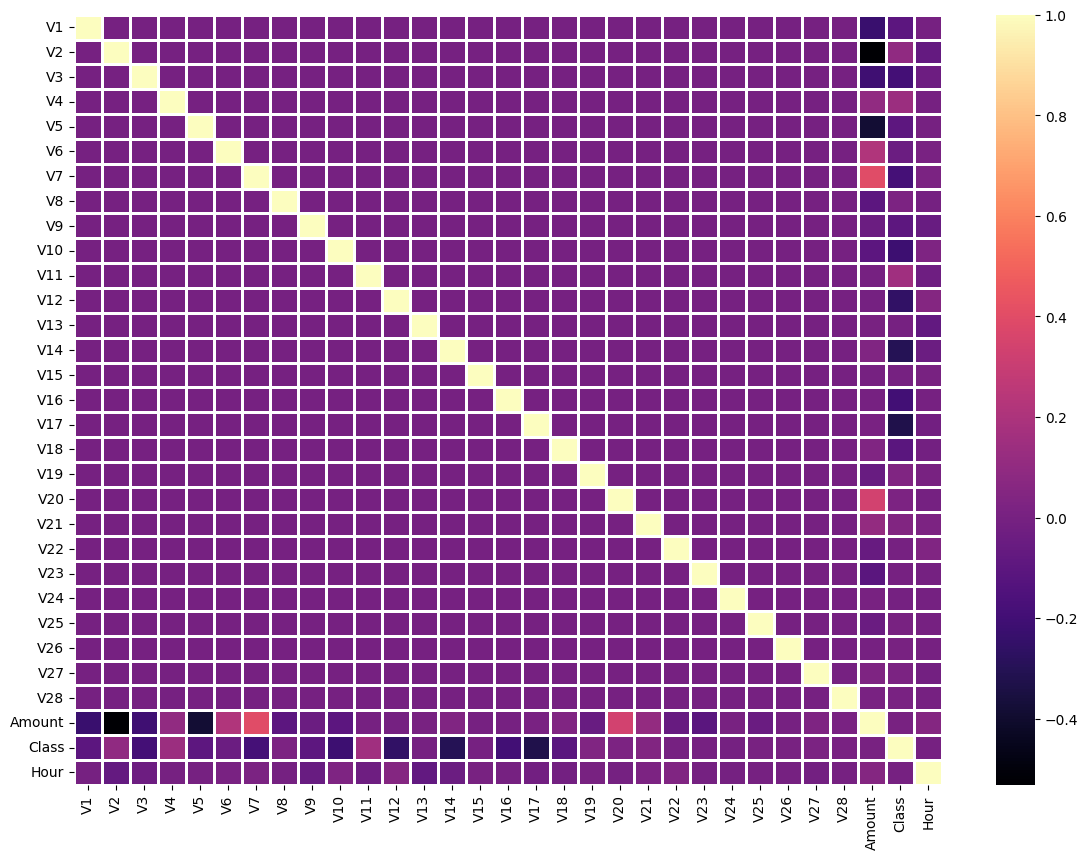

In [58]:
correlation= dataDF.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation, cmap="magma", linecolor='white',linewidths=1)


In [47]:
# Split the data into training and test sets with stratified sampling on the "Class" column
trainDF, testDF = train_test_split(dataDF, test_size=0.2, random_state=1234, stratify=dataDF["Class"])

In [48]:
# Calculate the percentage of fraudulent transactions in the training set
tr_value_counts = trainDF["Class"].value_counts()
print("Fraudulent transactions are %.2f%% of the training set." % (tr_value_counts[1] * 100 / len(trainDF)))

# Calculate the percentage of fraudulent transactions in the test set
tst_value_counts = testDF["Class"].value_counts()
print("Fraudulent transactions are %.2f%% of the test set." % (tst_value_counts[1] * 100 / len(testDF)))

Fraudulent transactions are 0.17% of the training set.
Fraudulent transactions are 0.17% of the test set.


In [49]:
# # Split the data into training and test sets with stratified sampling on the "Class" column
# trainDF, testDF = train_test_split(dataDF, test_size=0.2, random_state=1234, stratify=dataDF["Class"])

# # Create normalized versions of "Amount" and "Hour" columns in the training set
# trainDF_norm = trainDF.copy()
# trainDF_norm["Amount"] = trainDF["Amount"].subtract(trainDF["Amount"].mean())
# trainDF_norm["Hour"] = trainDF["Hour"].subtract(trainDF["Hour"].mean())

# # Create normalized versions of "Amount" and "Hour" columns in the test set
# testDF_norm = testDF.copy()
# testDF_norm["Amount"] = testDF["Amount"].subtract(testDF["Amount"].mean())
# testDF_norm["Hour"] = testDF["Hour"].subtract(testDF["Hour"].mean())

# # Update trainDF and testDF with normalized values
# trainDF = trainDF_norm
# testDF = testDF_norm

# # Calculate the percentage of fraudulent transactions in the training set
# tr_value_counts = trainDF["Class"].value_counts()
# print("Fraudulent transactions are %.2f%% of the training set." % (tr_value_counts[1] * 100 / len(trainDF)))

# # Calculate the percentage of fraudulent transactions in the test set
# tst_value_counts = testDF["Class"].value_counts()
# print("Fraudulent transactions are %.2f%% of the test set." % (tst_value_counts[1] * 100 / len(testDF)))


In [50]:
# # Next, we drop the Time attribute as we will be using Hour instead.

# trainDF = trainDF.drop(["Time"], axis=1)
# testDF = testDF.drop(["Time"], axis=1)

In [51]:
# Now let's split the independent and the class variables into separate data frames.

X_train = trainDF.iloc[:, trainDF.columns != "Class"]
y_train = trainDF.iloc[:, trainDF.columns == "Class"]
X_test = testDF.iloc[:, testDF.columns != "Class"]
y_test = testDF.iloc[:, testDF.columns == "Class"]
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Hour
135152,1.082,-0.075,1.395,1.373,-0.958,0.077,-0.625,0.205,0.861,-0.248,...,-0.012,0.204,0.063,0.399,0.298,-0.400,0.089,0.039,11.500,4.000
103706,1.013,0.188,1.615,2.594,-0.609,0.839,-0.683,0.400,-0.260,0.597,...,0.017,0.218,0.074,0.230,0.185,-0.046,0.059,0.027,6.800,0.000
231651,-0.701,0.090,1.540,-3.114,0.458,0.431,0.183,0.195,-1.230,-0.503,...,-0.069,-0.367,-0.449,-1.461,0.628,-0.475,0.004,0.027,12.000,22.000
199939,-0.430,-0.595,0.676,-2.603,1.499,4.231,-1.079,1.239,-0.798,-0.003,...,-0.015,0.214,0.090,0.694,-0.698,0.592,0.158,0.166,45.900,18.000
103404,1.296,1.011,-3.192,0.472,3.350,2.433,0.190,0.622,-0.557,-1.487,...,-0.263,-0.825,-0.245,0.675,1.011,-0.279,0.041,0.091,4.990,0.000


### Oversampling
#### Using SMOTE to rectify the imbalance in our dataset is fairly easy,

In [52]:
X_train_smote, y_train_smote = SMOTE(random_state=1234).fit_resample(X_train, y_train)
smote_value_counts = y_train_smote["Class"].value_counts()
print("Fraudulent transactions are %.2f%% of the train set." % (smote_value_counts[0] * 100 / len(y_train_smote)))
print('Now that the class imbalance has been resolved')

Fraudulent transactions are 50.00% of the train set.
Now that the class imbalance has been resolved


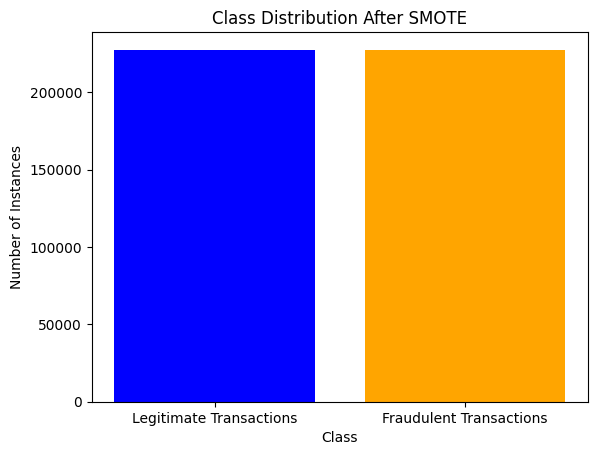

In [53]:
class_names = ["Legitimate Transactions", "Fraudulent Transactions"]
colors = ['blue', 'orange']
plt.bar(class_names, smote_value_counts, color=colors)
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution After SMOTE')
plt.show()

## XGBoost Model training

1. We will now train an XGBoost classifier, using the oversampled training set. 
2. We do a parameter search over the hyperparameters given in params -
    1.The cross-validation strategy for each model uses 3 folds in a stratified KFold
    2.The metric the models in the search are evaluated on is the Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    3.The function prints the parameters that yield the highest AUC score and returns the parameters of the best estimator as its output

In [54]:
def xgboost_search(X, y, search_verbose=1):
    params = {
    "gamma":[0.5, 1, 1.5, 2, 5],
    "max_depth":[3,4,5,6],
    "min_child_weight": [100],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "learning_rate": [0.1, 0.01, 0.001]
    }
    xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

    grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring="roc_auc", n_jobs=1, cv=skf.split(X,y), verbose=search_verbose)

    grid_search.fit(X, y)

    print("Best estimator: ")
    print(grid_search.best_estimator_)
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)

    return grid_search.best_params_

1. As the training set is quite large, we limit the grid search to a sample of 5000 observations. After xgboost_search goes through all possible estimators it will print the parameters used for the best performing one, and will return an XGBClassifier object that we can use to check how well the model generalises.

**2. Note, that although we are using a relatively small subset of the training data, the search still needs to train over 1,600 models, and this will take awhile.**

In [55]:
rows = random.sample(np.arange(0,len(X_train_smote.index)).tolist(), 5000)
model_params = xgboost_search(X_train_smote.iloc[rows,], y_train_smote.iloc[rows,])

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 3 folds for each of 540 candidates, totalling 1620 fits


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encode

Best estimator: 
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=100, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Parameters:  {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 100, 'subsample': 1.0}
Highest AUC: 0.98


#### Now that we have the set of parameters that produces the highest score, we can use them to train a model on the complete oversampled training set.

In [56]:
model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
model.set_params(**model_params)
model.fit(X_train_smote, y_train_smote)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=100, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

 ## XGBoost Model evaluation

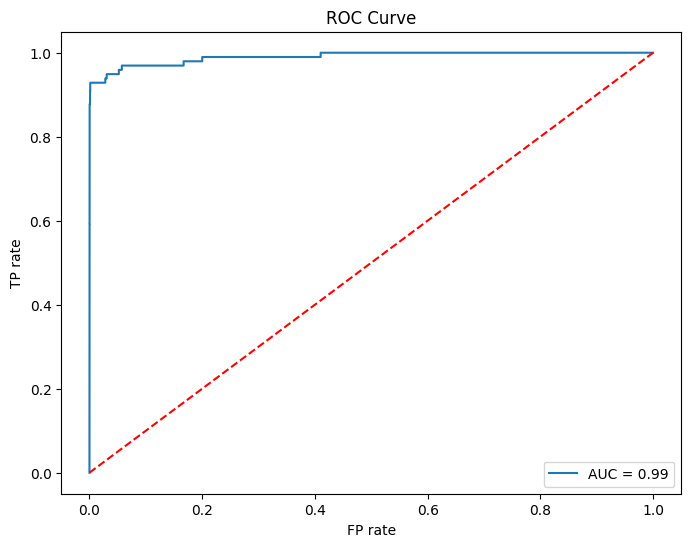

In [57]:
y_pred = model.predict_proba(X_test)[:, 1]

fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred)

auc = metrics.auc(fp_r, tp_r)

plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0, 1], [0, 1], "r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()


## Random Forest Model Training 

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def random_forest_search(X, y, search_verbose=1):
    params = {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["auto", "sqrt"],
        "bootstrap": [True, False]
    }
    
    rf = RandomForestClassifier(random_state=1234)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

    grid_search = GridSearchCV(estimator=rf, param_grid=params, scoring="roc_auc", n_jobs=1, cv=skf.split(X, y), verbose=search_verbose)

    grid_search.fit(X, y)

    print("Best estimator: ")
    print(grid_search.best_estimator_)
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)

    return grid_search.best_params_

# Call the random_forest_search function with your data
# best_rf_params = random_forest_search(X_train, y_train)


In [60]:
rows_rf = random.sample(np.arange(0,len(X_train_smote.index)).tolist(), 5000)
model_params = random_forest_search(X_train_smote.iloc[rows_rf,], y_train_smote.iloc[rows_rf,])

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConvers

Best estimator: 
RandomForestClassifier(bootstrap=False, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=1234)
Parameters:  {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Highest AUC: 1.00


In [61]:
from sklearn.ensemble import RandomForestClassifier
# Assuming you have defined your best Random Forest hyperparameters in 'best_rf_params'
# best_rf_params = {...}

# Create a Random Forest classifier with the specified hyperparameters
rf_model = RandomForestClassifier(**model_params, random_state=1234)

# Train the Random Forest classifier on the balanced SMOTE dataset
rf_model.fit(X_train_smote, y_train_smote)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(bootstrap=False, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=1234)

## Random Forest model Evaluation 

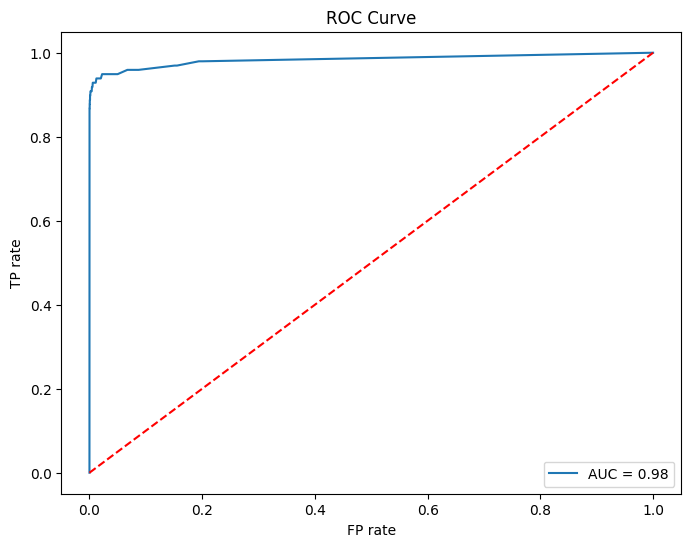

In [62]:
y_pred = rf_model.predict_proba(X_test)[:, 1]

fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred)

auc = metrics.auc(fp_r, tp_r)

plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0, 1], [0, 1], "r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()


## Results 

**1. Implemented XGBoost and Random Forest algorithms and achieved a remarkable AUC score of 0.97 using the XGBoost Classifier.**

**2. Implemented SMOTE effectively to address class imbalance, a critical factor in enhancing model accuracy.**
